# 00_1_DESIGN_Homologs

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/00_1_DESIGN_Homologs.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture
!pip install pydna
!pip install constrain
!pip install matplotlib
!pip install Bio

In [6]:
from Bio.Blast import NCBIWWW
from Bio.Seq import Seq
from Bio import SeqIO
blast = True
import pathlib
from Bio.Blast import NCBIXML
import pandas as pd
import numpy as np
import os

## 1. Intro

This notebook is made to be able to find homologs from protein queries. As a **test case** the G8H step in the Strictosidine pathway was chosen.  

**Some background on Strictosidine:** 
Strictosidine is a precurser for several anti-cancer compounds and is interesting because it is extracted from plants and due to weather and agricultural pests yields vary year to year (Brown et al., 2015). Additionally, Strictosidine is difficult to chemically synthesisze. Therefore we want to take the prouction to a yeast cell factory. However, the G8H (cytochrome p450) part of the pathway is the limiting step of the pathway and we want to optimize that via combinatorial optimizition. We have therefore chosen this step as test case for developing algorithms that can standardize homolog selection. The pathway is shown below.

This notebook has been developed to answer the following question:

**Can we via algorithms determine and standardize homolog selection?** 



In [3]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


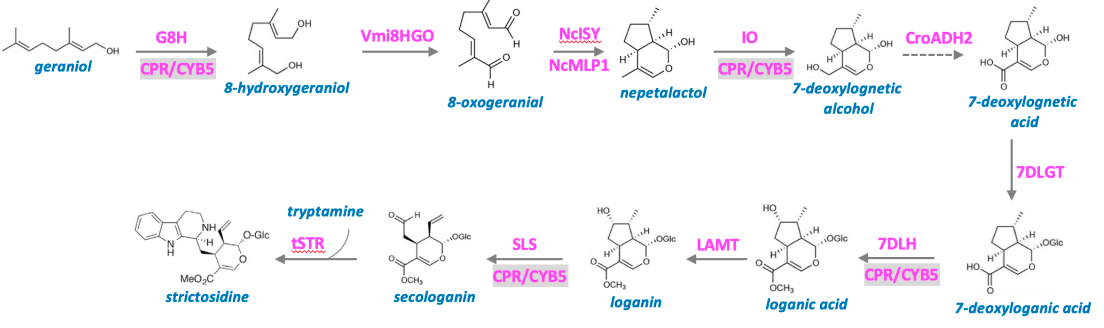

In [4]:
from IPython import display
display.Image('ConStrain_on_google_colab/pictures/Strictosidine_pathway.png')

**Main objective:**

- Finding Homologs for G8H, a major bottleneck in the Strictosidine pathway. More specifically two groups: 
    - G8H-CYP (Cytochrome p450)
    - G8H-CPR (Cytochrome p450 reductase)
    

**The method/algorithm for finding the set of homologs is described as follows:**

1. Read in the protein sequence of interest
2. BLAST the sequence with the Biopython NCBIWWW.qblast function and select “blastp”. 
3. Search through the newly generated alignment XML file and find proteins that fit your parameters and save ACC numbers. Parameters included here are: 
    - Identity: 50-95% 
    - E-value threshold 0.04
4. The ACC numbers are then used for fetching the protein sequences and saved as a FASTA file. 
5. The protein sequences are then made into DNA sequences in a 2 step process.
6. A temporary DNA sequence is made from a translation table
7. Codon optimized with “DNA chisel” for the organism of choice.
8. The codon-optimized sequences are made into Biopython SeqRecord objects and can be: 
    - Exported to a database of choice through an API (Benchling, Teselagen)
    - Saved as a FASTA file. 


## 2. G8H BLAST

#### First we make a file path for the fasta file we want to blast

In [ ]:
pathCroG8H = 'ConStrain_on_google_colab/Data/Protein_seqs/Q8VWZ7.FASTA'
pathCroG8H

#### Then we read it into a Seqrecord object with biopython

In [6]:
croG8H = SeqIO.read(pathCroG8H, format="fasta")
croG8H

SeqRecord(seq=Seq('MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSL...STL'), id='sp|Q8VWZ7|C76B6_CATRO', name='sp|Q8VWZ7|C76B6_CATRO', description='sp|Q8VWZ7|C76B6_CATRO Geraniol 8-hydroxylase OS=Catharanthus roseus OX=4058 GN=CYP76B6 PE=1 SV=1', dbxrefs=[])

In [7]:
print('LENGTH OF THE PROTEIN: ',len(croG8H.seq))
print(croG8H.seq)

LENGTH OF THE PROTEIN:  493
MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSLAKLSKKHGPIMSLKLGQITTIVISSSTMAKEVLQKQDLAFSSRSVPNALHAHNQFKFSVVWLPVASRWRSLRKVLNSNIFSGNRLDANQHLRTRKVQELIAYCRKNSQSGEAVDVGRAAFRTSLNLLSNLIFSKDLTDPYSDSAKEFKDLVWNIMVEAGKPNLVDFFPLLEKVDPQGIRHRMTIHFGEVLKLFGGLVNERLEQRRSKGEKNDVLDVLLTTSQESPEEIDRTHIERMCLDLFVAGTDTTSSTLEWAMSEMLKNPDKMKKTQDELAQVIGRGKTIEESDINRLPYLRCVMKETLRIHPPVPFLIPRKVEQSVEVCGYNVPKGSQVLVNAWAIGRDETVWDDALAFKPERFMESELDIRGRDFELIPFGAGRRICPGLPLALRTVPLMLGSLLNSFNWKLEGGMAPKDLDMEEKFGITLQKAHPLRAVPSTL


### 2.1 Blasting it on NCBI

In [25]:
%%time
result_handle = NCBIWWW.qblast("blastp", "nr", sequence=croG8H,   hitlist_size=150) # format_type='Text', # 3000

CPU times: user 222 ms, sys: 27.9 ms, total: 250 ms
Wall time: 4min 1s


#### 2.1.1 Write the blast onto an XML file 

In [26]:
blast_result = open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_homologs.xml", "w")
blast_result.write(result_handle.read())
blast_result.close()
result_handle.close()

#### 2.1.2 Open the generated file and read it into a variable 

In [27]:
from Bio.Blast import NCBIXML

with open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_homologs.xml", "r") as result_handle:
    blast_record = NCBIXML.read(result_handle)

#### 2.1.3. Filter BLAST results, on E-value, percentage protein identity

In [53]:
E_VALUE_THRESH = 0.4
LOWER_PROTEIN_IDENTITY_THRESH = 0.1
UPPER__PROTEIN_IDENTITY_THRESH = 0.99999
Alignments_that_follow_our_criteria = [] #These are the ACC numbers

# saving some of the metrics
Names = []
Identity = []
E_value = []
Length = []
ACC_number = []

counter = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        IDENTITY = (hsp.identities/len(croG8H))# hsp.align_length)
        if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH:
            counter += 1
            #print("\nAlignment#", counter)
            #print("Name:", alignment.hit_def)
            #print("Title:", alignment.title)
            #print("Length:", alignment.length)
            #print("E value:", hsp.expect)
            #print('Query:', hsp.query[0:75] + "...")
            #print('Match:', hsp.match[0:75] + "...")
            #print('Subjt:',hsp.sbjct[0:75] + "...")
            #print('Identitiy', "{:.2f}".format(IDENTITY))
            #print(alignment)
            #
            # Saving the metrics we want into different lists
            Alignments_that_follow_our_criteria.append(alignment)
            Names.append(alignment.hit_def)
            Identity.append(IDENTITY)
            E_value.append(hsp.expect)
            Length.append(alignment.length)
            ACC_number.append(alignment.accession)
            
print('\nTOTAL HOMOLOGS', counter)


TOTAL HOMOLOGS 1837


#### 2.1.4 Display results in a pandas dataframe 

Note: The alignments are saved onto a Bio.Blast.Record.Alignment datatype

In [29]:
Alignments_that_follow_our_criteria[0].hit_def

'RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]'

In [30]:
import pandas as pd

In [31]:
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 100)


In [32]:
data = list(zip(Names,Identity, E_value, Length, ACC_number))
df_alignments_that_follow_our_criteria = pd.DataFrame(data, columns=['Name','Identity', 'E_value', 'Length', 'ACC_number'])

# Sort dataframe  
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria.sort_values(by='Identity', ascending=False)
print(len(df_alignments_that_follow_our_criteria))
df_alignments_that_follow_our_criteria.head(10)

154


Name  \
0   RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]   
4                                                                                                                                                                                                                                                                                                                                                                 geraniol 10-hydroxylase-like protein [Cinchona calisaya]   
6                                                                                                                                                                                                                                                                                                                                                                             geraniol 10-hydroxylase [Gentiana rigescens]   
5                                                                                                                                                                                                                                                                                                                                                                             geraniol 10-hydroxylase [Gentiana rigescens]   
1                                                                                                                                                                                                                                                                                                                                                           geraniol 10-hydroxylase-like protein [Tabernaemontana elegans]   
3                                                                                                                                                                                                                                                                                                                                                              geraniol 10-hydroxylase-like protein [Rauvolfia serpentina]   
2                                                                                                                                                                                                                                                                                                                                                                geraniol 10-hydroxylase-like protein [Amsonia hubrichtii]   
8                                                                                                                                                                                                                                                                                                                                                                                                G10H [Gentiana rigescens]   
9                                                                                                                                                                                                                                                                                                                                                       hypothetical protein BUALT_Bualt04G0118100 [Buddleja alternifolia]   
10                                                                                                                                                                                                                                                                        

We need to narrow down the candidtates. One way to do this is to select is to take a range of amino acid identeties. another way is to limit the length to be more similar to the native enzyme


In [33]:
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria[ df_alignments_that_follow_our_criteria['Length'] > len(croG8H)-50]
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria[ df_alignments_that_follow_our_criteria['Length'] <len(croG8H)+50]
len(df_alignments_that_follow_our_criteria)

104

In [34]:
# Sorting the dataframe
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria.sort_values(by='Identity', ascending=False)
df_alignments_that_follow_our_criteria

Name  \
0    RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]   
1                                                                                                                                                                                                                                                                                                                                                            geraniol 10-hydroxylase-like protein [Tabernaemontana elegans]   
2                                                                                                                                                                                                                                                                                                                                                                 geraniol 10-hydroxylase-like protein [Amsonia hubrichtii]   
3                                                                                                                                                                                                                                                                                                                                                               geraniol 10-hydroxylase-like protein [Rauvolfia serpentina]   
4                                                                                                                                                                                                                                                                                                                                                                  geraniol 10-hydroxylase-like protein [Cinchona calisaya]   
..                                                                                                                                                                                                                                                                                                                                                                                                                      ...   
128                                                                                                                                                                                                                                                                                                                                                              PREDICTED: geraniol 8-hydroxylase-like [Nicotiana tabacum]   
139                                                                                                                                                                                                                                                                                                                                                        geraniol 8-hydroxylase-like [Pyrus ussuriensis x Pyrus communis]   
95                                                                                                                                                                                                                                                                                                                                                                            geraniol 8-hydroxylase-like [Ipomoea triloba]   
116                                                                                                                                                                                                                                                              

#### 2.1.5 Choosing homologs



The idea is to create a diverse library. Therefore I chose the following homologs with AA identeties ranging from our query to 66.6% AA identity.

In [35]:
chosen_homologs = ['Q8VWZ7','AGX93055','AGX93051' ,'AGX93053' , 'BAP90522', 'XP_022858342', 'D1MI46','AES93118']

In [36]:
chosen_homologs_df = df_alignments_that_follow_our_criteria[df_alignments_that_follow_our_criteria['ACC_number'].isin(chosen_homologs)]
print(len(chosen_homologs_df))
chosen_homologs_df

7


Name  \
0    RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]   
3                                                                                                                                                                                                                                                                                                                                                               geraniol 10-hydroxylase-like protein [Rauvolfia serpentina]   
4                                                                                                                                                                                                                                                                                                                                                                  geraniol 10-hydroxylase-like protein [Cinchona calisaya]   
10                                                                                                                                                                                                                                                                                                                                                              geraniol 8-hydroxylase-like [Olea europaea var. sylvestris]   
142                                                                                                                                                                                                                                                                                                                                                                      geraniol 10-hydroxylase-like protein [Vinca minor]   
7                                                                                                                                                                                                                                                                                                                                                                              geraniol 10-hydroxylase [Ophiorrhiza pumila]   
90                                                                                                                                                                                                             RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B10; AltName: Full=Geraniol 10-hydroxylase; Short=SmG10H [Swertia mussotii] >gb|ACZ48680.1| geraniol 10-hydroxylase [Swertia mussotii]   

     Identity       E_value  Length    ACC_number  
0    0.964912  3.274450e-27     493        Q8VWZ7  
3    0.754386  5.123990e-20     493      AGX93053  
4    0.754386  1.318650e-19     493      AGX93051  
10   0.736842  1.466650e-18     494  XP_022858342  
142  0.719298  6.581610e-08     493      AGX93055  
7    0.704918  2.454820e-19     512      BAP90522  
90   0.666667  1.403400e-08     495        D1MI46

Additionally i chose the AES93118 which looks promising from the following paper : https://www.nature.com/articles/srep08227

In [37]:
extra_G8H_dict = {'Name': 'geraniol-10-hydroxylase [Camptotheca acuminata]', 'Identity': np.nan, 'E_value': np.nan, 'Length':np.nan, 'ACC_number': 'AES93118' }

extra_G8H_df = pd.DataFrame([extra_G8H_dict])

chosen_homologs_df = pd.concat([chosen_homologs_df, extra_G8H_df], ignore_index=True)
len(chosen_homologs_df)

8

In [38]:
acc_numbers = chosen_homologs_df['ACC_number'].tolist()
Names_species = chosen_homologs_df['Name'].tolist()
acc_numbers

['Q8VWZ7',
 'AGX93053',
 'AGX93051',
 'XP_022858342',
 'AGX93055',
 'BAP90522',
 'D1MI46',
 'AES93118']

## 3. Retrieve the sequences and write them onto a file

### 3.1 Getting DNA sequences through Entrez 

Retrieve the sequences with the Entrez library which is possible with the ACC numbers we found before. Save the retrieved sequences as a fasta file called 'Homolog_seqs.fasta'. You need to provide an email for this so they know who you are. 

In [39]:
from Bio import Entrez

In [40]:
%%time

# add ur email here
email = "youremail@gmail.com"

out_handle = open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_Homolog_seqs.fasta', "w")

for i in range(0, len(acc_numbers)):
    Entrez.email = email
    handle = Entrez.efetch(db="protein", id=acc_numbers[i], rettype="fasta", retmode="text")
    
    out_handle.write(handle.read())
out_handle.close()

CPU times: user 239 ms, sys: 26.8 ms, total: 266 ms
Wall time: 5.8 s


### 3.2 Read the sequences into variables

Now parse through the file and get all the AA sequences which can be made into to DNA later. 

In [41]:
fasta_sequences = SeqIO.parse(open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_Homolog_seqs.fasta'),'fasta')
names = []
sequences = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    print(name, sequence, '\n')
    sequences.append(str(sequence)+'*')

print(len(sequences))

sp|Q8VWZ7.1|C76B6_CATRO MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSLAKLSKKHGPIMSLKLGQITTIVISSSTMAKEVLQKQDLAFSSRSVPNALHAHNQFKFSVVWLPVASRWRSLRKVLNSNIFSGNRLDANQHLRTRKVQELIAYCRKNSQSGEAVDVGRAAFRTSLNLLSNLIFSKDLTDPYSDSAKEFKDLVWNIMVEAGKPNLVDFFPLLEKVDPQGIRHRMTIHFGEVLKLFGGLVNERLEQRRSKGEKNDVLDVLLTTSQESPEEIDRTHIERMCLDLFVAGTDTTSSTLEWAMSEMLKNPDKMKKTQDELAQVIGRGKTIEESDINRLPYLRCVMKETLRIHPPVPFLIPRKVEQSVEVCGYNVPKGSQVLVNAWAIGRDETVWDDALAFKPERFMESELDIRGRDFELIPFGAGRRICPGLPLALRTVPLMLGSLLNSFNWKLEGGMAPKDLDMEEKFGITLQKAHPLRAVPSTL 

AGX93053.1 MDYLTITLGLLFALTFYQGLSYLSRRSKKLPPGPAPLPIIGNLHMLGDQPHKSLAKLSKKHGPIMSLKLGQITTVVVSSSGMAKEVLQKHDLAFSSRSIPNALHAHNQYQFSVVWLPVASRWRSLRKTLNSNIFSGNRLDANQHLRSRKVEELIAYCRKNCQTGEAVDVGRAAFRTSLNLLSNLIFSKDLTDPYSDSAKEFKDLVWNIMVEAGKPNLVDYFPVLEKVDPQGIRRRMTVHFGKVLKLFDGLVNERLEQRRSRGGKNDVLDVLLTNSEENPEEIDRTHIERMCLDLFVAGTDTTSSTLEWAMAEMLKNPDKMKKTQAELAEVIGRGKAIEESDLPRLPYLRCVVKETLRIHPPVPFLIPRRVEQDVEVCGYKVPKGSQVLVNAWTIGRDEAVWEDALAFKPERFLESELDIRGRDFELIPFGAGRRICPGLPLALRTVPLMVGSLLNSFNWKLEGGITPKD

## 4. Codon optimize it for yeast

In [42]:
for i in range(len(sequences)):
    if '-' in sequences[i]: 
        pos = sequences[i].find('-')
        print(pos)
        sequences[i] = sequences[i][0:pos]
        

In [43]:
sequences

['MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSLAKLSKKHGPIMSLKLGQITTIVISSSTMAKEVLQKQDLAFSSRSVPNALHAHNQFKFSVVWLPVASRWRSLRKVLNSNIFSGNRLDANQHLRTRKVQELIAYCRKNSQSGEAVDVGRAAFRTSLNLLSNLIFSKDLTDPYSDSAKEFKDLVWNIMVEAGKPNLVDFFPLLEKVDPQGIRHRMTIHFGEVLKLFGGLVNERLEQRRSKGEKNDVLDVLLTTSQESPEEIDRTHIERMCLDLFVAGTDTTSSTLEWAMSEMLKNPDKMKKTQDELAQVIGRGKTIEESDINRLPYLRCVMKETLRIHPPVPFLIPRKVEQSVEVCGYNVPKGSQVLVNAWAIGRDETVWDDALAFKPERFMESELDIRGRDFELIPFGAGRRICPGLPLALRTVPLMLGSLLNSFNWKLEGGMAPKDLDMEEKFGITLQKAHPLRAVPSTL*',
 'MDYLTITLGLLFALTFYQGLSYLSRRSKKLPPGPAPLPIIGNLHMLGDQPHKSLAKLSKKHGPIMSLKLGQITTVVVSSSGMAKEVLQKHDLAFSSRSIPNALHAHNQYQFSVVWLPVASRWRSLRKTLNSNIFSGNRLDANQHLRSRKVEELIAYCRKNCQTGEAVDVGRAAFRTSLNLLSNLIFSKDLTDPYSDSAKEFKDLVWNIMVEAGKPNLVDYFPVLEKVDPQGIRRRMTVHFGKVLKLFDGLVNERLEQRRSRGGKNDVLDVLLTNSEENPEEIDRTHIERMCLDLFVAGTDTTSSTLEWAMAEMLKNPDKMKKTQAELAEVIGRGKAIEESDLPRLPYLRCVVKETLRIHPPVPFLIPRRVEQDVEVCGYKVPKGSQVLVNAWTIGRDEAVWEDALAFKPERFLESELDIRGRDFELIPFGAGRRICPGLPLALRTVPLMVGSLLNSFNWKLEGGITPKDLDMEEKFGITLQKAHPLRAVPIPF*',
 '

We can use DNA chisel to backtranslate the sequences and afterwards codon optimize them. 

In [44]:
from dnachisel.biotools import reverse_translate

### First we just make a dummy dna sequece from the protein seq
protein_to_dna = []

for i in range(0, len(sequences)): 
    aa_seq = str(sequences[i])
    protein_to_dna.append(reverse_translate(aa_seq))
print(len(protein_to_dna))
print(protein_to_dna[1]) 

8
ATGGATTATTTAACTATTACTTTAGGTTTATTATTTGCTTTAACTTTTTATCAAGGTTTATCTTATTTATCTCGTCGTTCTAAAAAATTACCTCCTGGTCCTGCTCCTTTACCTATTATTGGTAATTTACATATGTTAGGTGATCAACCTCATAAATCTTTAGCTAAATTATCTAAAAAACATGGTCCTATTATGTCTTTAAAATTAGGTCAAATTACTACTGTTGTTGTTTCTTCTTCTGGTATGGCTAAAGAAGTTTTACAAAAACATGATTTAGCTTTTTCTTCTCGTTCTATTCCTAATGCTTTACATGCTCATAATCAATATCAATTTTCTGTTGTTTGGTTACCTGTTGCTTCTCGTTGGCGTTCTTTACGTAAAACTTTAAATTCTAATATTTTTTCTGGTAATCGTTTAGATGCTAATCAACATTTACGTTCTCGTAAAGTTGAAGAATTAATTGCTTATTGTCGTAAAAATTGTCAAACTGGTGAAGCTGTTGATGTTGGTCGTGCTGCTTTTCGTACTTCTTTAAATTTATTATCTAATTTAATTTTTTCTAAAGATTTAACTGATCCTTATTCTGATTCTGCTAAAGAATTTAAAGATTTAGTTTGGAATATTATGGTTGAAGCTGGTAAACCTAATTTAGTTGATTATTTTCCTGTTTTAGAAAAAGTTGATCCTCAAGGTATTCGTCGTCGTATGACTGTTCATTTTGGTAAAGTTTTAAAATTATTTGATGGTTTAGTTAATGAACGTTTAGAACAACGTCGTTCTCGTGGTGGTAAAAATGATGTTTTAGATGTTTTATTAACTAATTCTGAAGAAAATCCTGAAGAAATTGATCGTACTCATATTGAACGTATGTGTTTAGATTTATTTGTTGCTGGTACTGATACTACTTCTTCTACTTTAGAATGGGCTATGGCTGAAATGTTAAAAAATCCTGATAAAATGAAAAAAACTCAAGCTGAATTAGCTGAAGTTATTGGTCG

### 4.1 DNA chisel

Here the DNA is codon optimized for s_cerevisiae with DNA chisel

In [45]:
### Using DNA chisel to optimize the pattern: 
list_of_names = ['CroG8H_tADH1',
                'RsepG8H_tADH1',
                'CcalG8H_tADH1',
                'OeuG8H_tADH1', 
                'VminG8H_tADH1',
                'OpumG8H_tADH1',
                'SmusG8H_tADH1',
                'CacuG8H_tADH1']



from dnachisel import *

codon_optimized_seqs = []

# DEFINE THE OPTIMIZATION PROBLEM
for i in range(0, len(protein_to_dna)):
    problem = DnaOptimizationProblem(
                                        sequence=protein_to_dna[i], 
                                        constraints=[EnforceGCContent(mini=0.3, maxi=0.7, window=50)],
                                        objectives=[CodonOptimize(species='s_cerevisiae')]
                                    )

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE
    problem.resolve_constraints()
    problem.optimize()
    
    
    #
    print(problem.constraints_text_summary())
    print(problem.objectives_text_summary())

    # GET THE FINAL SEQUENCE AS ANNOTATED BIOPYTHON RECORDS)
    final_record = problem.to_record(with_sequence_edits=True)
    final_record.id = acc_numbers[i]
    final_record.name = list_of_names[i]
    final_record.description = Names_species[i]
    
    codon_optimized_seqs.append(final_record)

location:   0%|                                | 0/191 [00:00<?, ?it/s, now=3-6]
                                                                                
location:   0%|                                | 0/191 [00:00<?, ?it/s, now=3-6]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1482](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.64
     -1.64 ┍ MaximizeCAI[0-1482](s_cerevisiae) 
           │ Codon opt. on window 0-1482 scored -1.64E+00




location:   0%|                               | 0/169 [00:00<?, ?it/s, now=9-12]
                                                                                
location:   0%|                               | 0/169 [00:00<?, ?it/s, now=9-12]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1482](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -2.19
     -2.19 ┍ MaximizeCAI[0-1482](s_cerevisiae) 
           │ Codon opt. on window 0-1482 scored -2.19E+00




location:   0%|                               | 0/163 [00:00<?, ?it/s, now=9-12]
                                                                                
location:   0%|                               | 0/163 [00:00<?, ?it/s, now=9-12]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1482](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -0.55
     -0.55 ┍ MaximizeCAI[0-1482](s_cerevisiae) 
           │ Codon opt. on window 0-1482 scored -5.47E-01




location:   0%|                                | 0/181 [00:00<?, ?it/s, now=3-6]
                                                                                
location:   0%|                                | 0/181 [00:00<?, ?it/s, now=3-6]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1485](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:         0
✔        0 ┍ MaximizeCAI[0-1485](s_cerevisiae) 
           │ Codon opt. on window 0-1485 scored -0.00E+00




location:   0%|                                | 0/160 [00:00<?, ?it/s, now=0-3]
                                                                                
location:   0%|                                | 0/160 [00:00<?, ?it/s, now=0-3]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1482](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:         0
✔        0 ┍ MaximizeCAI[0-1482](s_cerevisiae) 
           │ Codon opt. on window 0-1482 scored -0.00E+00




location:   0%|                                | 0/170 [00:00<?, ?it/s, now=3-6]
                                                                                
location:   0%|                                | 0/170 [00:00<?, ?it/s, now=3-6]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1539](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.64
     -1.64 ┍ MaximizeCAI[0-1539](s_cerevisiae) 
           │ Codon opt. on window 0-1539 scored -1.64E+00




location:   0%|                                | 0/167 [00:00<?, ?it/s, now=0-3]
                                                                                
location:   0%|                                | 0/167 [00:00<?, ?it/s, now=0-3]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1488](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.09
     -1.09 ┍ MaximizeCAI[0-1488](s_cerevisiae) 
           │ Codon opt. on window 0-1488 scored -1.09E+00




location:   0%|                                | 0/165 [00:00<?, ?it/s, now=3-6]
                                                                                
location:   0%|                                | 0/165 [00:00<?, ?it/s, now=3-6]
                                                                                

===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1506](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.09
     -1.09 ┍ MaximizeCAI[0-1506](s_cerevisiae) 
           │ Codon opt. on window 0-1506 scored -1.09E+00




In [46]:
codon_optimized_seqs

[SeqRecord(seq=Seq('ATGCCATCTTTGACTATTATGAGAGCTTTGTTGCCAGCTTTGACTGTTTCTGAT...TAA'), id='Q8VWZ7', name='CroG8H_tADH1', description='RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATTATTTGACTCCAACTCCAGGTTTGTTTGTTGCCTTGACTTTGTATCAA...TAA'), id='AGX93053', name='RsepG8H_tADH1', description='geraniol 10-hydroxylase-like protein [Rauvolfia serpentina]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGTATTGTTTGACTCCATATTTGGGTTTGGTTTTTGCTTTGACTACTTATCAA...TAA'), id='AGX93051', name='CcalG8H_tADH1', description='geraniol 10-hydroxylase-like protein [Cinchona calisaya]', dbxrefs=[]),
 SeqRecord(seq=Seq('TTGGAATTTTTG

Writing the sequences into a fasta_file

In [47]:
with open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_seqs)):
        print(codon_optimized_seqs[i].format("fasta"), file = outfile)

## 5. CPR BLAST


- The CPR was found in the article: De novo production of the plant-derived alkaloid strictosidine in yeast, under suplementary information
- From the fasta-file we have the CPR protein sequece and then we can repeat what was done above for finding G8H homologs 

In [48]:
G8H_CPR = SeqIO.read('ConStrain_on_google_colab/Data/Protein_seqs/Q05001.1.fasta', format="fasta")
G8H_CPR

SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...DVW'), id='sp|Q05001.1|NCPR_CATRO', name='sp|Q05001.1|NCPR_CATRO', description='sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cytochrome P450 reductase; Short=CPR; Short=P450R', dbxrefs=[])

In [49]:
print(G8H_CPR.seq)

MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILTTSVAVLIGCVVVLIWRRSSGSGKKVVEPPKLIVPKSVVEPEEIDEGKKKFTIFFGTQTGTAEGFAKALAEEAKARYEKAVIKVIDIDDYAADDEEYEEKFRKETLAFFILATYGDGEPTDNAARFYKWFVEGNDRGDWLKNLQYGVFGLGNRQYEHFNKIAKVVDEKVAEQGGKRIVPLVLGDDDQCIEDDFAAWRENVWPELDNLLRDEDDTTVSTTYTAAIPEYRVVFPDKSDSLISEANGHANGYANGNTVYDAQHPCRSNVAVRKELHTPASDRSCTHLDFDIAGTGLSYGTGDHVGVYCDNLSETVEEAERLLNLPPETYFSLHADKEDGTPLAGSSLPPPFPPCTLRTALTRYADLLNTPKKSALLALAAYASDPNEADRLKYLASPAGKDEYAQSLVANQRSLLEVMAEFPSAKPPLGVFFAAIAPRLQPRFYSISSSPRMAPSRIHVTCALVYEKTPGGRIHKGVCSTWMKNAIPLEESRDCSWAPIFVRQSNFKLPADPKVPVIMIGPGTGLAPFRGFLQERLALKEEGAELGTAVFFFGCRNRKMDYIYEDELNHFLEIGALSELLVAFSREGPTKQYVQHKMAEKASDIWRMISDGAYVYVCGDAKGMARDVHRTLHTIAQEQGSMDSTQAEGFVKNLQMTGRYLRDVW


### 5.1 Blasting on NCBI

Have already done this - if you want to try you can do it again or else move to the next cell were the results are loaded in.


In [55]:
%%time
result_handle1 = NCBIWWW.qblast("blastp", "nr", sequence = G8H_CPR.seq, hitlist_size=150)
#
## Writing the results into an XML files so we dont have to blast every time
blast_result1 = open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs.xml", "w")
blast_result1.write(result_handle1.read())
blast_result1.close()
result_handle1.close()

CPU times: user 151 ms, sys: 34.8 ms, total: 185 ms
Wall time: 2min 3s


#### 5.1.1 Write the blast onto an XML file 

In [56]:
from Bio.Blast import NCBIXML

with open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs.xml", "r") as result_handle1:
    blast_record = NCBIXML.read(result_handle1)

#### 5.1.2 Filter BLAST results, on E-value, percentage protein identity

In [52]:
E_VALUE_THRESH = 0.04
LOWER_PROTEIN_IDENTITY_THRESH = 0.1
UPPER__PROTEIN_IDENTITY_THRESH = 0.99999
#AA_length_min = 704
#AA_length_max = 724
Alignments_that_follow_our_criteria1 = []

# saving the blast results
Names = []
Identity = []
E_value = []
Length = []
ACC_number = []

counter = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        IDENTITY = (hsp.identities/ hsp.align_length)
        LENGTH = alignment.length 
        # We add the added reqirement that the sequence should be +-10 amino acids 
        if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH:

        #if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH and LENGTH > AA_length_min and LENGTH<AA_length_max :
            counter += 1            
            # Saving into different lists
            Alignments_that_follow_our_criteria1.append(alignment)
            Names.append(alignment.hit_def)
            Identity.append(IDENTITY)
            E_value.append(hsp.expect)
            Length.append(alignment.length)
            ACC_number.append(alignment.accession)
            
print('\nTOTAL HOMOLOGS', counter)


TOTAL HOMOLOGS 2527


Now we can sort the results in a dataframe 

In [ ]:
data = list(zip(Names,Identity, E_value, Length, ACC_number))
df_with_CPR = pd.DataFrame(data, columns=['Name','Identity', 'E_value', 'Length', 'ACC_number'])
df_with_CPR = df_with_CPR.sort_values(by=['Identity'])
df_with_CPR

Lets add our query 

In [ ]:
G8H_CPR.id = 'Q05001'
G8H_CPR_dict = {'Name': G8H_CPR.description, 'Identity': 1, 'E_value': 0, 'Length':len(G8H_CPR.seq), 'ACC_number': G8H_CPR.id }
CPR_df = pd.DataFrame([G8H_CPR_dict])

df_with_CPR = pd.concat([CPR_df, df_with_CPR], ignore_index=True)

In [ ]:
df_with_CPR = df_with_CPR[ df_with_CPR['Length'] > len(G8H_CPR)-100]
df_with_CPR = df_with_CPR[ df_with_CPR['Length'] <len(G8H_CPR)+100]
len(df_with_CPR)

#### 5.1.3 Choosing CPRs

In [ ]:
interesting_cprs = ['Q05001','KAI5675352', 'Q1PQK4', 'Q9SB48', 'Q00141' , 'AJW67229', 'XP_022867604', 'A0A0C5DKP2', 'AFX82679', 'QEG78946']


In [ ]:
chosen_cpr_df = df_with_CPR[df_with_CPR['ACC_number'].isin(interesting_cprs)].sort_values(by=['Identity'], ascending=False)
chosen_cpr_df

From a literature search the following enzymes were found: 

- Q1PQK4 # Acts as a redox partner for CYP71AV1 found  #https://www.nature.com/articles/nrmicro3240#Sec9
- Q00141 # 
- Q9SB48 #  Found in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6906673/ 
- A0A0C5DKP2 # Found in https://www.nature.com/articles/s41586-022-05157-3#Sec23
- CAA49446 # # Found in https://www.nature.com/articles/s41586-022-05157-3#Sec23

    

In [ ]:
list_of_cprs_from_literature =['Q1PQK4', 'Q00141','Q9SB48', 'A0A0C5DKP2', 'AFX82679']

for name in list_of_cprs_from_literature:
    listen = [name,np.nan, np.nan,'NaN',name]
    chosen_cpr_df.loc[len(chosen_cpr_df)] = listen

len(chosen_cpr_df)

In [ ]:
chosen_cpr_df

In [ ]:
acc_numbers = chosen_cpr_df['ACC_number'].tolist()
acc_numbers

We have to narrow it down the search make a library of feasible size. 

Lets try to sample every 6 from the sorted dataframe. THat way we get CPRs that have different amino acid identities and reduce the number of parts. 


In [ ]:
#rate = 250
#subset = df_with_CPR.sort_values(by = 'Identity', ascending = False)[::rate]
#print(len(subset))
#subset

In [ ]:
#acc_numbers = subset['ACC_number'].tolist()
#acc_numbers

Now we blast we get all the sequences from the accession numbers

### 5.2 Retrieve the sequences and write them onto a file

In [ ]:
%%time

email = "youremail@gmail.com"

out_handle = open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homolog_protein_seqs.fasta', "w")

for i in range(0, len(acc_numbers)):
    Entrez.email = email
    handle = Entrez.efetch(db="protein", id=acc_numbers[i], rettype="fasta", retmode="text")
    
    out_handle.write(handle.read())
    
out_handle.close()

#### Read in the sequences into variables


Now we can parse through the file and get all the AA sequences which we can make to DNA later. 

In [ ]:
fasta_sequences = SeqIO.parse(open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homolog_protein_seqs.fasta'),'fasta')
names = []
sequences = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    sequences.append(str(sequence)+'*')
    

### 5.3 Codon optimize it for yeast

We can do the same as before of first making a dummy dna sequence with the use of the synbiopython translation table

In [ ]:
### First we just make a dummy dna sequece from the protein seq
protein_to_dna = []

for i in range(0, len(sequences)): 
    aa_seq = str(sequences[i])
    protein_to_dna.append(reverse_translate(aa_seq))
print(len(protein_to_dna))
print(protein_to_dna[1]) 

#### Now for making codon_optimized DNA from our protein sequences:  DNA chisel

In [ ]:
### Using DNA chisel to optimize the pattern: 

from dnachisel import *

codon_optimized_seqs1 = []

# DEFINE THE OPTIMIZATION PROBLEM
for i in range(0, len(protein_to_dna)):
    problem = DnaOptimizationProblem(
        sequence=protein_to_dna[i], 
        constraints=[EnforceGCContent(mini=0.3, maxi=0.7)],
        objectives=[CodonOptimize(species='s_cerevisiae')]
    )

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE
    problem.resolve_constraints()
    problem.optimize()

    # GET THE FINAL SEQUENCE AS ANNOTATED BIOPYTHON RECORDS)
    final_record = problem.to_record(with_sequence_edits=True)
    final_record.id = acc_numbers[i]
    final_record.name = 'G8H_CPR {}'.format(i)
    final_record.description = Names_species[i]
    
    codon_optimized_seqs1.append(final_record)

In [ ]:
codon_optimized_seqs1

Writing the sequences into a fasta_file

In [ ]:
with open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_seqs1)):
        print(codon_optimized_seqs1[i].format("fasta"), file = outfile)

## 5. -  ONE-KB Plant database BLAST

<!-- My_api_key:

4772e3e5-57ce-4b75-a3a8-06c49a2e202d -->

### 5.1 Importing the results from 1 kb

In [ ]:
import pandas as pd

We can do a search on 1kb 
**Interesting organisms:** 

Catharanthus raseus

Rauvalfia serpentina

Olea eurapaea

Camptatheca acuminata

Vinca minar

Cinchana calisaya

Ophiarrhiza pumila


Swertia mussatii

Artemisia annua 

Arabidopsis thaliana

Catharanthus langifalius

Amsania hubrichtii 

- non-plants

Chrysamela papuli

Aspergillus niger


In [ ]:
#ZwayQgpYDmtHyLK5
#PWF5MET7016 

In [ ]:
g8h_1kb = pd.read_table('ConStrain_on_google_colab/Data/one_kb_protein_sequences/One_KB_G8H_tabular.txt')
cpr_1kb = pd.read_table('ConStrain_on_google_colab/Data/one_kb_protein_sequences/One_KB_CPR_tabular.txt')


# Sorting the data: 
g8h_1kb = g8h_1kb.sort_values(by='Percentage of identical matches', ascending=False )
cpr_1kb = cpr_1kb.sort_values(by='Percentage of identical matches' , ascending=False)
#list_of_g8h = g8h_1kb['']
g8h_1kb

In [ ]:
list_of_species_names = ['Catharanthus roseus', 'Rauvolfia serpentina','Olea europaea', 'Camptotheca acuminata', 'Vinca minor', 
                         'Cinchona calisaya', 'Ophiorrhiza pumila', 'Swertia mussatii', 'Artemisia annua', 'Arabidopsis thaliana', 
                        'Catharanthus longifolius','Amsonia hubrichtii' , 'Chrysomela populi', 'Aspergillus niger']

In [ ]:
df1 = g8h_1kb[g8h_1kb['Subject Scientific Name'].isin(list_of_species_names)]
df1

Lets investigate the second option gnl|onekp|TORX_scaffold_2008758

In [ ]:
G8H_sites =[]
for seq_record in SeqIO.parse('ConStrain_on_google_colab/Data/one_kb_protein_sequences/One_KB_G8H.fasta', format= 'fasta'):
    G8H_sites.append(seq_record)


for name in G8H_sites: 
    if name.name == 'gnl|onekp|TORX_scaffold_2013179': 
        G8H_2008758 = name

print(G8H_2008758.seq)

In [ ]:

df2 = cpr_1kb[cpr_1kb['Subject Scientific Name'].isin(list_of_species_names)]
df2

In [ ]:

g8h_1kb_cro = g8h_1kb[g8h_1kb['Subject Scientific Name'] == 'Vinca minor' ]
g8h_1kb_cro

## 6. Phylogenetic tree

So there are a few alignment tools for python but most of them are full of bugs. Therefore the protein sequences can just be entered to this website and from there we can download an alignment file for making phylogenetic trees.

### 6.1 G8H

In [268]:
from Bio import AlignIO

alignment = AlignIO.read(open("ConStrain_on_google_colab/Data/Protein_seqs/aln-stockholm_g8h.txt"), "stockholm")
print("Alignment length %i" % alignment.get_alignment_length())
for record in alignment:
    print(record.seq + " " + record.id)

Alignment length 517
----------------MDIMDFMSFFIMFFGHLQIVSSPTTAASCKGCKKASTGPKPFPVIGNLLDVVGNQPHKSLANLAKTHGPLMTLKLGQITTVVVSSSTMAKQILQNHDLYFSNRYTRDAIRALNQDQFSVIWLPVVTRWRNLRKILNLYMLSTERLGANQPIRCQKVEELIAYVRQSCQASVSVDIGQAAFRTMINLTSKTIFSVDLADPSSDTAQELKELFWRIMEELGKPNLADYFPVLRKLDPQGIRRRTTIHFAKVFDLFDRMIDQRLELLRSDDCCTGNDLLDSLLNISQNNSDEIDQNQIKRMLMDVFIAATDTTSSTLEWAMTELLRNPETLLKAKAELQQIVGKGKLVEELDIARLPYLQAIVKETFRLHTTVPFLIPRQVDEDVEVCGFTVPKGAQVLVNAWAIGHDPSIWPKPDSFMPERFLESEVDVRGLDFELIPFGGGRRICPGSALALRMLHLMLGSLINSFDWRLEDGIAPNDMDMEEKFGLSLQKARPLLFAPVHI AES93118.1
-----------------MDFDFLTIAIGFLFTITLY--QALNFFSRKSKNLPPGPSPLPLIGNL-HLLGDQPHKSLAKLAKKHGPIMGLQLGQVTTIVVTSSGMAKEVLQKQDLAFSSRSIPNAIHAHDQYKYSVIWLPVASRWRGLRKALNSNMFSGNRLDANQHLRSRKVQELIAYCRKSSQTGDAIDVGRAAFRTSLNLLSNTMFSKDLTDPYSDSAKEFKDLVWNVMVEAGKPNLVDYFPLLDKVDPQGIRKRMTIHFGKILELFGGLIDERLQQKKAKG--VNDDVLDVLLTTSEESPEEIDRTHIQRMCLDLFVAGTDTTSSTLEWAMSEMLKNPEKMKAAQAELAQVIGKGKAVEEADLARLPYLRCAIKETLRIHPPVPLLIPRRTEQEVEVCGYTVPKNSQVLVNVWAISRDDAIWKDPLSFKPERFLESELEMRGKDFEL

In [269]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)

AES93118.1	0
sp|D1MI46.1|C76BA_SWEMU	0.41972920696324956	0
XP_022858342.1	0.4100580270793037	0.20309477756286265	0
AGX93055.1	0.4081237911025145	0.20696324951644096	0.18375241779497098	0
sp|Q8VWZ7.1|C76B6_CATRO	0.42166344294003866	0.1895551257253385	0.19148936170212771	0.1315280464216635	0
AGX93053.1	0.4003868471953579	0.1895551257253385	0.19535783365570603	0.1083172147001934	0.1063829787234043	0
AGX93051.1	0.39651837524177946	0.18181818181818177	0.16827852998065762	0.14700193423597674	0.15280464216634426	0.1353965183752418	0
BAP90522.1	0.41779497098646035	0.23017408123791105	0.19342359767891681	0.1644100580270793	0.19922630560928434	0.17601547388781436	0.14893617021276595	0
	AES93118.1	sp|D1MI46.1|C76BA_SWEMU	XP_022858342.1	AGX93055.1	sp|Q8VWZ7.1|C76B6_CATRO	AGX93053.1	AGX93051.1	BAP90522.1


In [270]:
dm.names

['AES93118.1',
 'sp|D1MI46.1|C76BA_SWEMU',
 'XP_022858342.1',
 'AGX93055.1',
 'sp|Q8VWZ7.1|C76B6_CATRO',
 'AGX93053.1',
 'AGX93051.1',
 'BAP90522.1']

In [271]:
list_of_names = ['CacG8H', 'SmuG8H','OeuG8H','VmiG8H','CroG8H','RseG8H','CcaG8H','OpuG8H']
for i in range(len(list_of_names)):
    dm.names[i] = list_of_names[i]

One way to figure this out is to use the Clustal Omega online tool: https://www.ebi.ac.uk/Tools/msa/clustalo/

1. Upload fasta file with all sequences
2. THis was done and a lot of homology was found between the G8H CPR and CYP. This information can be found in the files folder


In [272]:
from Bio import Phylo
import pylab
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

In [275]:
for leaf in tree.get_terminals(): 
    print(leaf.name)

OpuG8H
CcaG8H
RseG8H
CroG8H
VmiG8H
OeuG8H
SmuG8H
CacG8H


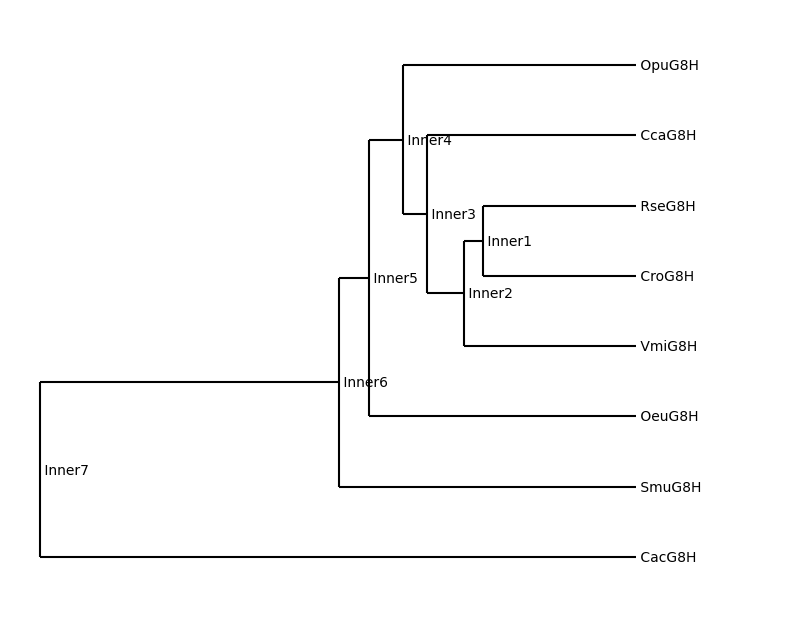

In [273]:
import matplotlib
import matplotlib.pyplot as plt

# set the size of the figure
fig = plt.figure(figsize=(10, 8), dpi=100)

plt.rcParams.update({'font.size':10})
axes = fig.add_subplot(1, 1, 1)


fig1 = plt.gcf()
Phylo.draw(tree, axes=axes, do_show=False, branch_labels=None)
pylab.axis('off')
# homologs
plt.rcParams.update({'font.size':10})

#axes.text(0.85, 0.5, ' CroG8H \n\n\n\n\n\ CcalG8H \n\n\n\n\n OpumG8H \n\n\n\n\n CacuG8H \n\n\n\n\n RsepG8H \n SmusG8H \n\n\n\n\n VminG8H \n OeuG8H \n\n SmusG8H', horizontalalignment='center',
#     verticalalignment='center', transform=axes.transAxes)


None

### 6.2 CPR



In [268]:
from Bio import AlignIO

alignment = AlignIO.read(open("ConStrain_on_google_colab/Data/Protein_seqs/aln-stockholm_g8h.txt"), "stockholm")
print("Alignment length %i" % alignment.get_alignment_length())
for record in alignment:
    print(record.seq + " " + record.id)

Alignment length 517
----------------MDIMDFMSFFIMFFGHLQIVSSPTTAASCKGCKKASTGPKPFPVIGNLLDVVGNQPHKSLANLAKTHGPLMTLKLGQITTVVVSSSTMAKQILQNHDLYFSNRYTRDAIRALNQDQFSVIWLPVVTRWRNLRKILNLYMLSTERLGANQPIRCQKVEELIAYVRQSCQASVSVDIGQAAFRTMINLTSKTIFSVDLADPSSDTAQELKELFWRIMEELGKPNLADYFPVLRKLDPQGIRRRTTIHFAKVFDLFDRMIDQRLELLRSDDCCTGNDLLDSLLNISQNNSDEIDQNQIKRMLMDVFIAATDTTSSTLEWAMTELLRNPETLLKAKAELQQIVGKGKLVEELDIARLPYLQAIVKETFRLHTTVPFLIPRQVDEDVEVCGFTVPKGAQVLVNAWAIGHDPSIWPKPDSFMPERFLESEVDVRGLDFELIPFGGGRRICPGSALALRMLHLMLGSLINSFDWRLEDGIAPNDMDMEEKFGLSLQKARPLLFAPVHI AES93118.1
-----------------MDFDFLTIAIGFLFTITLY--QALNFFSRKSKNLPPGPSPLPLIGNL-HLLGDQPHKSLAKLAKKHGPIMGLQLGQVTTIVVTSSGMAKEVLQKQDLAFSSRSIPNAIHAHDQYKYSVIWLPVASRWRGLRKALNSNMFSGNRLDANQHLRSRKVQELIAYCRKSSQTGDAIDVGRAAFRTSLNLLSNTMFSKDLTDPYSDSAKEFKDLVWNVMVEAGKPNLVDYFPLLDKVDPQGIRKRMTIHFGKILELFGGLIDERLQQKKAKG--VNDDVLDVLLTTSEESPEEIDRTHIQRMCLDLFVAGTDTTSSTLEWAMSEMLKNPEKMKAAQAELAQVIGKGKAVEEADLARLPYLRCAIKETLRIHPPVPLLIPRRTEQEVEVCGYTVPKNSQVLVNVWAISRDDAIWKDPLSFKPERFLESELEMRGKDFEL

In [269]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)

AES93118.1	0
sp|D1MI46.1|C76BA_SWEMU	0.41972920696324956	0
XP_022858342.1	0.4100580270793037	0.20309477756286265	0
AGX93055.1	0.4081237911025145	0.20696324951644096	0.18375241779497098	0
sp|Q8VWZ7.1|C76B6_CATRO	0.42166344294003866	0.1895551257253385	0.19148936170212771	0.1315280464216635	0
AGX93053.1	0.4003868471953579	0.1895551257253385	0.19535783365570603	0.1083172147001934	0.1063829787234043	0
AGX93051.1	0.39651837524177946	0.18181818181818177	0.16827852998065762	0.14700193423597674	0.15280464216634426	0.1353965183752418	0
BAP90522.1	0.41779497098646035	0.23017408123791105	0.19342359767891681	0.1644100580270793	0.19922630560928434	0.17601547388781436	0.14893617021276595	0
	AES93118.1	sp|D1MI46.1|C76BA_SWEMU	XP_022858342.1	AGX93055.1	sp|Q8VWZ7.1|C76B6_CATRO	AGX93053.1	AGX93051.1	BAP90522.1


In [270]:
dm.names

['AES93118.1',
 'sp|D1MI46.1|C76BA_SWEMU',
 'XP_022858342.1',
 'AGX93055.1',
 'sp|Q8VWZ7.1|C76B6_CATRO',
 'AGX93053.1',
 'AGX93051.1',
 'BAP90522.1']

In [271]:
list_of_names = ['CacG8H', 'SmuG8H','OeuG8H','VmiG8H','CroG8H','RseG8H','CcaG8H','OpuG8H']
for i in range(len(list_of_names)):
    dm.names[i] = list_of_names[i]

One way to figure this out is to use the Clustal Omega online tool: https://www.ebi.ac.uk/Tools/msa/clustalo/

1. Upload fasta file with all sequences
2. THis was done and a lot of homology was found between the G8H CPR and CYP. This information can be found in the files folder


In [272]:
from Bio import Phylo
import pylab
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

In [275]:
for leaf in tree.get_terminals(): 
    print(leaf.name)

OpuG8H
CcaG8H
RseG8H
CroG8H
VmiG8H
OeuG8H
SmuG8H
CacG8H


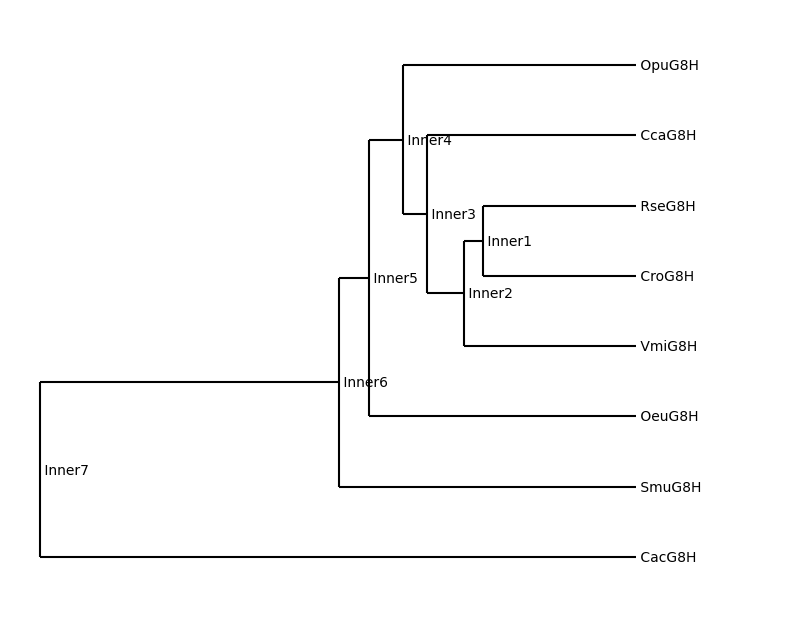

In [273]:
import matplotlib
import matplotlib.pyplot as plt

# set the size of the figure
fig = plt.figure(figsize=(10, 8), dpi=100)

plt.rcParams.update({'font.size':10})
axes = fig.add_subplot(1, 1, 1)


fig1 = plt.gcf()
Phylo.draw(tree, axes=axes, do_show=False, branch_labels=None)
pylab.axis('off')
# homologs
plt.rcParams.update({'font.size':10})

#axes.text(0.85, 0.5, ' CroG8H \n\n\n\n\n\ CcalG8H \n\n\n\n\n OpumG8H \n\n\n\n\n CacuG8H \n\n\n\n\n RsepG8H \n SmusG8H \n\n\n\n\n VminG8H \n OeuG8H \n\n SmusG8H', horizontalalignment='center',
#     verticalalignment='center', transform=axes.transAxes)


None

## 6. Homology analysis

### Does the the G8G_CYP and G8H_CPR share too much homology? 

We can present the result visually as a phylogenetic tree as shown below.

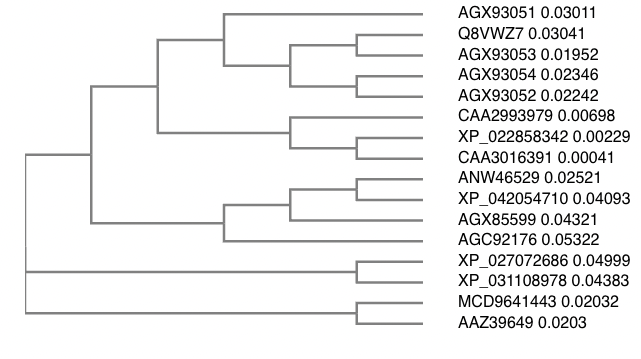

In [267]:
display.Image('ConStrain_on_google_colab/pictures/PHYLO_G8H_CYP_CPR.png')

Here it is clear that the CYPs and CPRs are clustered into their own clades. However, when looking closely at the clustal omega file there are found streches of DNA that show homology which could be a problem for integration. 

This problem could be alliviated by:
1. Integrateting the CYPs and CPRs seperately in different genomic locations. 
2. Changing the parameters of the Codon optimization in either the CYP step or the CPR step, or constraing DNA chisel to avoid the same sequences. DNA chisel has the UniquifyAllKmers to do this. 

## 7. Conclusion 

- 8 G8H CYPs were found and codon-optimized
- 8 CPRs were found and codon-optimized

## References: 
    
    
    

Brown, S., Clastre, M., Courdavault, V. and O’Connor, S., 2015. De novo production of the plant-derived alkaloid strictosidine in yeast. Proceedings of the National Academy of Sciences, 112(11), pp.3205-3210.